<a href="https://colab.research.google.com/github/LuisFelipeUrena/DS-Unit-2-Applied-Modeling/blob/master/Assignments/DS14_TL_LS_LUIS_URENA_3_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install pandas==0.23.4

In [3]:
#defining the dataframe pandas object   
df = pd.read_csv('myfxbookdata.csv')

df.head()

,Open Date,Close Date,Symbol,Action,Lots,SL,TP,Open Price,Close Price,Pips,Profit,Duration (DD:HH:MM:SS),Change %
0,04/02/2020 16:30,04/02/2020 23:59,GBPUSD,Sell,1.5,1.24420,1.23320,1.23720,1.23926,-20.6,-296.41,00:07:29:00,-0.28
1,04/02/2020 12:00,04/02/2020 13:22,GBPUSD,Buy,1.5,1.23533,1.24633,1.24233,1.24633,40.0,544.67,00:01:22:00,0.52
2,03/25/2020 18:00,03/25/2020 18:22,GBPUSD,Buy,1.5,1.16878,1.17978,1.17578,1.17978,40.0,544.67,00:00:22:00,0.53
3,03/25/2020 16:00,03/25/2020 16:18,GBPUSD,Sell,1.5,1.18371,1.17271,1.17671,1.17271,40.0,544.67,00:00:18:00,0.53
4,03/25/2020 11:00,03/25/2020 11:54,GBPUSD,Buy,1.5,1.18523,1.19623,1.19223,1.19623,40.0,544.67,00:00:54:00,0.53


In [0]:
#changing column names to lowercase
df.columns = df.columns.str.lower()

In [0]:
#changing column spaces and commas
df.columns = df.columns.str.replace(' ','_')

In [0]:
#here we are engeenering a new feature called win loss
#this feature will be the target of our model
#defined by determining if a trade made or lost money by negative
#and positive values
df['win/loss'] = df['profit'] > 0

In [0]:
#the labels pips and profit basically are data leakage since it will tell the out come of the trade itself
#in a real life application of the model, a trader will not know wether a trade made or lost money
df = df.drop(labels=['profit','pips'],axis=1)

In [0]:
#here we are making the open and close dates as a datetime format
df['open_date'] = pd.to_datetime(df['open_date'])
df['close_date'] = pd.to_datetime(df['close_date'])

In [0]:
#this is a brand new feature called risk reward ratio, basically it will tell us 
#if the risk vs reward measured in pip value is negative or positive on any given
#trade
multiplier = 0.0001

df['risk_reward'] = round((df['sl']-df['tp'])/multiplier)

In [0]:
#here we will make a time based split based on a cutoff date
cutoff = pd.to_datetime('2018/11/1') #the cutoff is 11/1/2018
train = df[df['open_date']<=cutoff] #train data will be trades taken before the cutoff date
test = df[df['open_date']>cutoff] # test data will be split on trades taken after the cutoff date

In [0]:
#here we hare instanciating our train/test sets to fit and test or model
target = 'win/loss'
features = ['action','sl','tp','open_price','close_price','risk_reward']

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [12]:
#here are some extra libraries for our modeling phase
!pip install category_encoders==2.
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


     |████████████████████████████████| 92kB 2.5MB/s 
  Found existing installation: category-encoders 2.1.0
    Uninstalling category-encoders-2.1.0:
      Successfully uninstalled category-encoders-2.1.0


In [0]:
#building our pipeline...
pipeline = make_pipeline(
    ce.BinaryEncoder(),
    RandomForestClassifier()
)

In [14]:
#here we are cheking for the cross validation after fitting the vanilla model
#also i'd like to add the baseline just for reference
import numpy as np
baseline = df['win/loss'].value_counts(normalize=True)
cvscore = cross_val_score(pipeline,X_train,y_train,cv=5)
print('Cross-validation score average:',np.mean(cvscore))
print('Cross-validation Standard Deviation:',np.std(cvscore))
print('Baseline Distribution: ',baseline)

Cross-validation score average: 0.7798508235781624
Cross-validation Standard Deviation: 0.041032574966641776
Baseline Distribution:  True     0.695988
False    0.304012
Name: win/loss, dtype: float64


In [15]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('binaryencoder',
                 BinaryEncoder(cols=None, drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               mapping=None, return_df=True, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                          

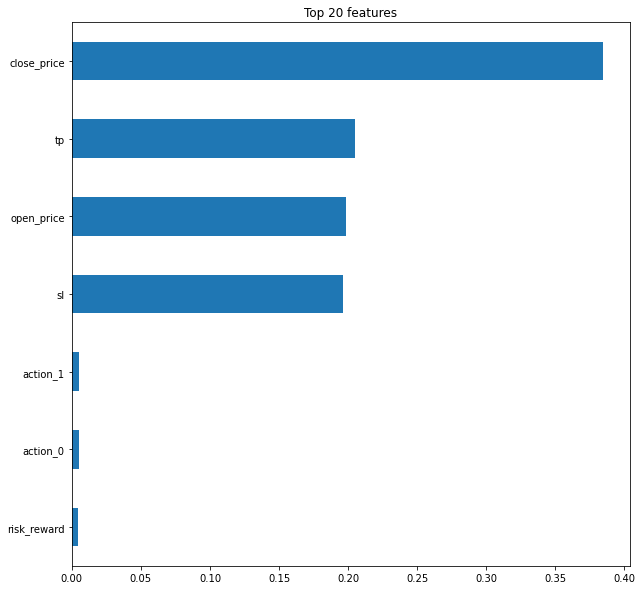

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
encoder = pipeline.named_steps['binaryencoder']
encoded = encoder.fit_transform(X_train)

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [23]:
rf.fit(encoded,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

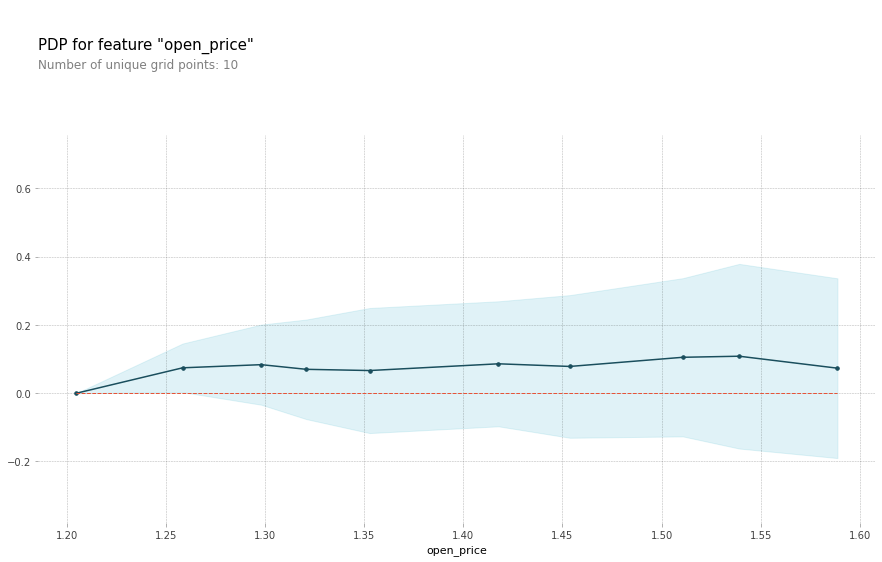

In [26]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'open_price'
X_encoded = encoder.transform(X_test)
pdp_dist = pdp.pdp_isolate(model=rf, dataset=encoded, model_features=X_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


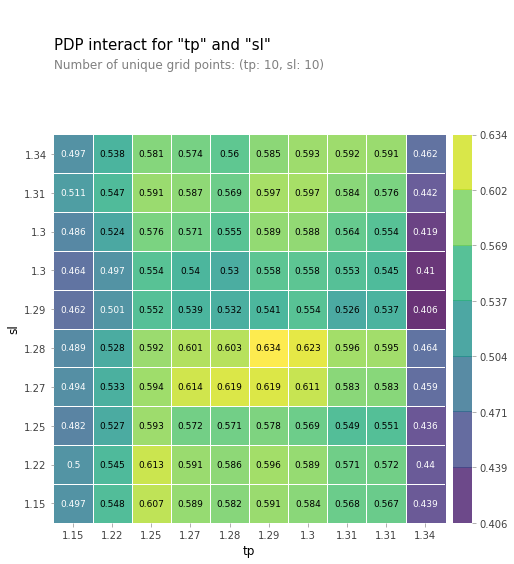

In [28]:
from pdpbox.pdp import pdp_interact,pdp_interact_plot
features = ['tp', 'sl']

interaction = pdp_interact(
    model=rf, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [30]:
#Shap force plot
row = X_test.iloc[[0]] #frst row features
row

,action,sl,tp,open_price,close_price,risk_reward
0,Sell,1.2442,1.2332,1.2372,1.23926,110.0


In [31]:
#actual outcome of this trade
y_test.iloc[[0]]

0    False
Name: win/loss, dtype: bool

In [32]:
#prediction of our  model
pipeline.predict(row)

array([False])

In [40]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot

import shap


explainer = shap.TreeExplainer(rf)
row_t = encoder.transform(row)
shap_values = explainer.shap_values(row_t)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=row,
    link='logit'
)

Exception: ignored